In [1]:
#import some useful packages

import numpy as np
from qiskit.visualization import array_to_latex
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_formats = ['svg']
import time
import os
import csv

import warnings
warnings.filterwarnings('ignore')

import time
import os
import csv

IBMProvider.save_account('030e0f3b6562aeef01f326920c2b5c95160de76135f801f67cce23704c77a274aa5241b45c7777d8a2bcfb4c71803c8796f4d6896241914aba81fc7281bae508', overwrite=True)

provider = IBMProvider()
backend = provider.get_backend('ibm_lagos')

In [2]:
#get information about backend
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()

In [1]:
#hyperparameters
qubit = 0
f01 = backend.properties().qubits[qubit][2].value * 1e9
anhar = backend.properties().qubits[qubit][3].value * 1e9
f12 = f01 + anhar

qubit = 0
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
sqrt = np.sqrt
NUM_SHOTS = 20000
scale_factor = 1e-7

amp12 = 0.28992251826581195
dur12 = 144
sig12 = dur12/4
dur01 = 160
sig01 = dur01/4

NameError: name 'backend' is not defined

In [4]:
#some useful function
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    return LDA_012

def count(data, discriminator):
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        #print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

def IQ_012_plot(x_min, x_max, y_min, y_max, data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

#mitigate
from cvxopt import matrix, solvers
def mitigated_population(p, C):
    P = matrix(np.transpose(C).dot(C))
    q = matrix(-np.transpose(p).dot(C))
    G = matrix([[-1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,-1.0]])
    h = matrix([0.0, 0.0, 0.0])
    A = matrix([1.0, 1.0, 1.0], (1,3))
    b = matrix(1.0)
    solvers.options['show_progress'] = False
    sol=solvers.qp(P, q, G, h, A, b)
    # return np.asarray(sol['x'])
    return np.array([e for e in sol['x']])

def get_population(data, discriminator):
    drag_values = count(data, discriminator)
    return np.asarray([[val['0']/NUM_SHOTS, val['1']/NUM_SHOTS, val['2']/NUM_SHOTS] for val in drag_values])

def get_mitigated_population(data, discriminator, confusion_matrix):
    population = get_population(data, discriminator)
    mitigated = [mitigated_population(pop, confusion_matrix) for pop in population]
    return np.asarray(mitigated)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#loss function
def loss_func(param, theta, phi, p_exp, N_data = 97):
  p_model = [population_model(theta[i], phi[i], *param, order) for i in range(N_data)]
  return mean_squared_error(p_model, population, squared = 'False')

In [5]:
#define matrix representaion of some gates
def Z01(phi):
    return np.array([[np.exp(-1j * phi), 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

def Z12(phi):
    return np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, np.exp(1j * phi)]])

def X01(theta):
    return np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2), 0],
                     [-1j * np.sin(theta / 2), np.cos(theta / 2), 0],
                     [0, 0, 1]])


def X12(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta / 2), -1j * np.sin(theta / 2)],
                     [0, -1j * np.sin(theta / 2), np.cos(theta / 2)]])
def R01_theory(theta, phi):
    return Z01(phi) @ X01(theta) @ Z01(-phi)
def R12_theory(theta, phi):
    return Z12(phi) @ X12(theta) @ Z12(-phi)

def R01(theta, phi, phi2):
  R01_theory = Z01(phi) @ X01(theta) @ Z01(-phi)
  return Z12(phi2) @ R01_theory

def R12(theta, phi, phi0, phi2):
  R12_theory = Z12(phi) @ X12(theta) @ Z12(-phi)
  return Z01(phi0) @ R12_theory @ Z12(phi2)

def U_d(phi_1, phi_2, phi_3):
    return np.array([[np.exp(1j*phi_1), 0, 0],
                   [0, np.exp(1j*phi_2), 0],
                   [0, 0, np.exp(1j*phi_3)]])

def R01_theory(theta, phi):
    return Z01(phi) @ X01(theta) @ Z01(-phi)

def R12_theory(theta, phi):
    return Z12(phi) @ X12(theta) @ Z12(-phi)
def population_model(thetas, phis, phi2_01, phi0_12, phi2_12, order):
    ground = np.array([[1], [0], [0]])
    psi =  R12(np.pi/2, 0, phi0_12, phi2_12) @ R01(np.pi/2, 0, phi2_01) @ ground
    i = 0
    for level in order:
        if level == '1':
            psi =  R01(thetas[i], phis[i], phi2_01) @ psi
        else :
            psi = R12(thetas[i], phis[i], phi0_12, phi2_12) @ psi
        i = i + 1
    return [np.abs(psi[0][0])**2, np.abs(psi[1][0])**2, np.abs(psi[2][0])**2]

In [6]:
#get information about default X gate
calibrations = backend_defaults.instruction_schedule_map
calibrations.get('x', qubit), calibrations.get('sx', qubit)

(Schedule((0, Play(Drag(duration=160, sigma=40, beta=-1.0789757601572947, amp=0.384205678130623, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x"),
 Schedule((0, Play(Drag(duration=160, sigma=40, beta=-1.1013886682356577, amp=0.1889428893585572, angle=0.023297991511911236, name='X90p_d0'), DriveChannel(0), name='X90p_d0')), name="sx"))

In [7]:
amp01 = 0.38639985577931224
#some useful pulse
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as xpi12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=dur12,
                            amp=amp12,
                            sigma=sig12,
                            name=r'$X_{\pi}^{(12)}$'), drive_chan)

with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(12)}$') as x90_12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=dur12,
                            amp=amp12/2,
                            sigma=sig12,
                            name=r'$X_{\pi/2}^{(12)}$'), drive_chan)
    
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as xpi01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Drag(duration=dur01,
                               amp=amp01,
                               sigma=sig01,
                               beta=-1.0509653466942652,
                               angle=0.0,
                               name=r'$X_{\pi}^{(01)}$'), drive_chan)

with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(01)}$') as x90_01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Drag(duration=dur01,
                               amp=0.19028167169061994,
                               sigma=sig01,
                               beta=-1.0849508117205746,
                               angle=0.022530958997040784,
                               name=r'$X_{\pi/2}^{(01)}$'), drive_chan)   

#define a pulse rotating theta around n-axis in subspace 0-1 and 1-2

def r01(theta, phi):
    with pulse.build(backend=backend, default_alignment='sequential', name=r'$R^{(01)}$') as r01_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f01, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur01,
                                      amp=amp01*theta/np.pi,
                                      sigma=sig01,
                                      name=r'$X_{\pi/2}^{(01)}$'), drive_chan)

    return r01_pulse

def r12(theta, phi):
    with pulse.build(backend=backend, default_alignment='sequential',
                     name=r'$R^{(12)}$') as r12_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f12, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur12,
                                      amp=amp12*theta/np.pi,
                                      sigma=sig12,
                                      name=r'$X_{\pi/2}^{(12)}$'), drive_chan)

    return r12_pulse

# Create the three circuits
Xpi01 = Gate("$X_{\pi}^{01}$", 1, [])
Xpi12 = Gate("$X_{\pi}^{12}$", 1, [])
X90_01 = Gate(r'$X_{\pi/2}^{(01)}$', 1, [])
X90_12 = Gate(r'$X_{\pi/2}^{(12)}$', 1, [])
# 0 state
zero = QuantumCircuit(1, 1)
zero.measure(0, 0)

# 1 state
one = QuantumCircuit(1, 1)

#one.append(Xpi01, [0])
#one.add_calibration(Xpi01, (0,), r01(pi, 0), [])
one.x(0)
one.measure(0, 0)

# 2 state 
two = QuantumCircuit(1, 1)
two.x(0)
#two.append(Xpi01, [0])
two.append(Xpi12, [0])
two.measure(0, 0)
#two.add_calibration(Xpi01, (0,), r01(pi, 0), [])
two.add_calibration(Xpi12, (0,), r12(pi, 0), [])

discr_circ = [zero, one, two]

In [1]:
import numpy as np

In [2]:
#alpha, beta, gamma = np.array([2.597187768207791800e-04, -5.579298251606725323e+00+2*pi, 6.786182131640287052e-01])
#alpha, beta, gamma = np.array([0.06990661, 0.75912952, 0.77966618])
alpha, beta, gamma = np.array([0.61004155, 0.72967769, 6.24307464])

In [9]:
def create_pulse_sequence(params_sequence):
    phase_01, phase_12 = 0, 0
    #print(alpha, beta, gamma)
    with pulse.build(backend=backend, default_alignment='sequential') as pulse_sequence:
        drive_channel = pulse.drive_channel(qubit)
        pulse.delay(0, drive_channel)
    for params in params_sequence:
        #print(params)
        theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = params
        
        with pulse.build(backend=backend, default_alignment='sequential') as sched:
            drive_channel = pulse.drive_channel(qubit)
            
            #R01(theta, phi)
            if theta_1 != 0:
                pulse.set_frequency(f01, drive_channel)
                pulse.call(r01(theta_1, phi_1 + phase_01))
                phase_12 = phase_12 + alpha
            
            #R12(theta, phi)
            if theta_2 != 0:
                pulse.set_frequency(f12, drive_channel)
                pulse.call(r12(theta_2, phi_2 + phase_12))
                phase_01 = phase_01 + beta
                phase_12 = phase_12 + gamma
            
            #R01(theta, phi)  
            if theta_3 != 0:
                pulse.set_frequency(f01, drive_channel)
                pulse.call(r01(theta_3, phi_3 + phase_01))
                phase_12 = phase_12 + alpha
            
            #U_d(phi6, phi5, phi4)
            phase_01 = phase_01 + phi_6 - phi_5
            phase_12 = phase_12 + phi_5 - phi_4

        pulse_sequence = pulse_sequence + sched
        #print(phase_01, phase_12)
    return pulse_sequence

In [10]:
# neutrino mixing parameters
t12 = np.radians(33.45)
t23 = np.radians(42.1)
t13 = np.radians(8.62)
D21 = 7.42*1e-5
D31 = 2.510*1e-3 
D32 = D31-D21 ###
# Abbreviation
c12 = cos(t12)
s12 = sin(t12)
c13 = cos(t13)
s13 = sin(t13)
c23 = cos(t23)
s23 = sin(t23)

In [11]:
### Start from electron
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import pandas as pd
import seaborn as sns
#bodacious colors
colors=sns.color_palette("rocket",3)
#Ram's colors, if desired
seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']
#            0sangre,   1neptune,  2pumpkin,  3clover,   4denim,    5cocoa,    6cumin,    7berry

In [12]:
def create_qc(sched):
    qc = QuantumCircuit(1,1)
    gate = Gate('Neutrino', 1, [])
    qc.append(gate, [0])
    qc.add_calibration(gate, (0,), sched, [])
    qc.measure(0,0)
    return qc

In [13]:
def parameters(a):
    Dee = c12**2*D31+s12**2*D32
    Dee_t = Dee*sqrt((cos(2*t13)-a/Dee)**2+sin(2*t13)**2)
    s13t_sq = 0.5*(1-(Dee*cos(2*t13)-a)/Dee_t)
    t13t = np.arcsin(sqrt(s13t_sq))
    a12 = 0.5*(a+Dee-Dee_t)
    D21t = D21*sqrt((cos(2*t12)-a12/D21)**2 + cos(t13-t13t)**2*sin(2*t12)**2)
    s12t_sq = 0.5*(1-(D21*cos(2*t12)-a12)/D21t)
    t12t = np.arcsin(sqrt(s12t_sq))
    D31t = D31+a/4+0.5*(D21t-D21)+0.75*(Dee_t-Dee)
    t23t = t23
    return t23t,t13t, t12t, D21t, D31t
def NeudCPMatter(dCP, initial, matter, sim):
    try:
        if initial == 'e':
            flavor_initial = [1,0,0]
        elif initial == 'm':
            flavor_initial = [0,1,0]
        elif initial == 't':
            flavor_initial = [0,0,1]
    except:
        print('start from e, m, t only')
    t23m, t13m, t12m, D21m, D31m = parameters(matter)
    dCPm = dCP
    c12m = cos(t12m)
    s12m = sin(t12m)
    c13m = cos(t13m)
    s13m = sin(t13m)
    c23m = cos(t23m)
    s23m = sin(t23m)
    
    Um = np.array([[c12m*c13m            , s12m*c13m             , s13m*exp(-1j*dCP)],
               [-s12m*c23m-c12m*s23m*s13m*exp(1j*dCP), c12m*c23m-s12m*s23m*s13m*exp(1j*dCP) , s23m*c13m],
               [s12m*s23m-c12m*c23m*s13m*exp(1j*dCP) , -c12m*s23m-s12m*c23m*s13m*exp(1j*dCP), c23m*c13m]])
    iUm = Um.conj().T
    # U1 = R01(pi/2+dCP, a1m)@R12(3*pi/2, a2m)@R01(pi/2+dCP, a3)@R01(pi/2,-2*t12m)
    # U1d = R01(pi/2, 2*t12m)@R01(pi/2+dCP, -a3m)@R12(3*pi/2, -a2m)@R01(pi/2+dCP, -a1m)
    e_survival1a = []
    mu_survival1a = []
    tau_survival1a = []
    conL = 5.06773
    
    for l in sim:
        l = l*conL
        evolmatrix = np.diag([1, exp(-1j*D21m*l/(2*E)), exp(-1j*l*D31m/(2*E))])
        # flavor = U1@evolmatrix@U1d@flavor_initial
        flavor = Um@evolmatrix@iUm@flavor_initial
        e_survival1a.append(np.absolute(flavor[0])**2)
        mu_survival1a.append(np.absolute(flavor[1])**2)
        tau_survival1a.append(np.absolute(flavor[2])**2)
    return e_survival1a, mu_survival1a, tau_survival1a

In [14]:
def get_parameter(U):
    #U = Clifford3_final[index]
    if np.round(abs(np.absolute(U[2, 2])), 6) == 1:
        if np.round(abs(np.absolute(U[0, 0])), 6) != 0:
            theta_1 = phi_1 = theta_2 = phi_2 = 0
            phi_4 = np.angle(U[2, 2])
            phi_5 = np.angle(U[1, 1])
            phi_6 = np.angle(U[0, 0])
            # phi_3 = phi_6 - pi/2 - np.angle(U[0, 1])
            phi_3 = np.angle(U[1, 0]) - phi_5 + pi/2
            theta_3 = 2*np.arccos(np.round(np.absolute(U[1, 1]), 6))
        else:
            theta_1 = phi_1 = theta_2 = phi_2 = phi_3 = 0
            theta_3 = 2*np.arccos(np.round(np.absolute(U[1, 1]), 6))
            phi_4 = np.angle(U[2, 2])
            phi_6 = np.angle(U[0, 1]) + phi_3 + pi/2
            phi_5 = np.angle(U[1, 0]) - phi_3 + pi/2
    elif np.round(abs(np.absolute(U[2, 2])), 6) == 0:
        theta_1 = 2*np.arccos(np.round(np.absolute(U[2, 1]), 6))
        theta_2 = pi
        theta_3 = 2*np.arccos(np.round(np.absolute(U[1, 2]), 6))
        phi_1 = phi_2 = phi_3 = 0
        if np.round(abs(np.absolute(U[2, 0])), 6) != 0:
            phi_4 = np.angle(-U[2, 0])
            if np.round(abs(np.absolute(U[0, 2])), 6) != 0:
                phi_5 = np.angle(-U[1, 1])
                phi_6 = np.angle(-U[0, 2])
            else:
                phi_5 = np.angle(U[1, 2]) + pi/2
                phi_6 = np.angle(U[0, 1]) + pi/2 
        if np.round(abs(np.absolute(U[1, 0])), 6) != 0:
            phi_4 = np.angle(U[2, 1]) + pi/2
            phi_5 = np.angle(U[1, 0]) + pi/2
            phi_6 = np.angle(-U[0, 2])
        if np.round(abs(np.absolute(U[0, 0])), 6) != 0:
            phi_4 = np.angle(U[2, 1]) + pi/2
            phi_5 = np.angle(U[1, 2]) + pi/2
            phi_6 = np.angle(U[1, 1])
        
    else:
        phi_4 = np.angle(U[2, 2])
        theta_2 = 2*np.arccos(np.round(np.absolute(U[2, 2]), 6))
        phi_2 = np.angle(U[2, 1]) - phi_4 + pi/2
        phi_1 = np.angle(-U[2, 0]) - phi_2 - phi_4
        theta_1 = 2*np.arccos(np.round(np.absolute(U[2, 1])/np.sin(theta_2/2), 6))
        theta_3 = 2*np.arccos(np.round(np.absolute(U[1, 2])/np.sin(theta_2/2), 6))
        phi_5 = np.angle(U[1, 2]) + phi_2 + pi/2
        phi_3 = np.angle(np.cos(theta_1/2) * np.cos(theta_2/2) * np.cos(theta_3/2) - U[1, 1]*np.exp(-1j*phi_5)) + phi_1
        phi_6 = np.angle(-U[0, 2]) + phi_3 + phi_2
    return theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6

def reconstruct(theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6):
    return U_d(phi_6, phi_5, phi_4) @ R01_theory(theta_3, phi_3) @ R12_theory(theta_2, phi_2) @ R01_theory(theta_1, phi_1)

In [16]:
time_range = np.linspace(0, 34000, 485)
time_range_splitted = np.split(time_range, 5)

In [48]:
#6 gates

electron_job_ids = []
for time_step in time_range_splitted:
    schedules = []
    for ii, l in enumerate(time_step):
        l = l*conL 
        d2 = D21m * l / (2 * E)
        d3 = D31m * l / (2 * E)
        phi_01 = d2
        phi_12 = -d2 + d3
        params_g4 = [alpha_3-2*theta_12, 0, 0, pi/2+phi_01, 0, 0, 0, 0, 0]
        params_g5 = [0, alpha_2, 0, 0, 3*pi/2+phi_12, 0, 0, 0, 0]
        params_g6 = [alpha_1, 0, 0, pi/2+phi_01, 0, 0, 0, 0, 0]
        new_sched = create_pulse_sequence([params_g1, params_g2, params_g3, params_g4, params_g5, params_g6])
        schedules.append(new_sched)
    exp_circs = [create_qc(schedule) for schedule in schedules]
    exp_circs = discr_circ + exp_circs 
    electron_job = backend.run(exp_circs, meas_level=1, meas_return='single', shots=NUM_SHOTS)
    electron_job_ids.append(electron_job.job_id())

In [18]:
electron_job_ids = ['cjffi60cs414jvgndjtg',
 'cjffi7fbq0tlksv5hud0',
 'cjffi9fbq0tlksv5i0ng',
 'cjffial7ui1f8qarfurg',
 'cjffibt7ui1f8qarg0lg']

In [19]:
datas = []
for id in electron_job_ids:
    job = provider.backend.retrieve_job(id)
    data = get_job_data(job, average=False)
    datas.append(data)

In [20]:
populations = []
for data in datas:
    discrim_data = data[:3]
    exp_data = data[3:]
    LDA_012 = discriminate(discrim_data)
    discr_data = count(discrim_data, LDA_012)
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)
    populations.append(population)

In [26]:
popus = np.concatenate((populations[0], populations[1], populations[2], populations[3], populations[4]))

In [36]:
Lmin = 0
Lmax = 34000
timestep_sim = 1000
timestep_exp = 485
xsim = np.linspace(Lmin, Lmax, timestep_sim)
xexp = np.linspace(Lmin, Lmax, timestep_exp)
etheo, mtheo, ttheo = NeudCPMatter(0, 'e', 0, xsim)[0], NeudCPMatter(0, 'e', 0, xsim)[1], NeudCPMatter(0, 'e', 0, xsim)[2]

In [51]:
from sklearn.metrics import r2_score
etheo_compared, mtheo_compared, ttheo_compared = NeudCPMatter(0, 'e', 0, xexp)[0], NeudCPMatter(0, 'e', 0, xexp)[1], NeudCPMatter(0, 'e', 0, xexp)[2]
good_or_bad = [r2_score(popus[:, 0], etheo_compared), r2_score(popus[:, 1], mtheo_compared), r2_score(popus[:, 2], ttheo_compared)]

In [52]:
good_or_bad

[0.9988891091485644, 0.9981737838095043, 0.9961208531161326]

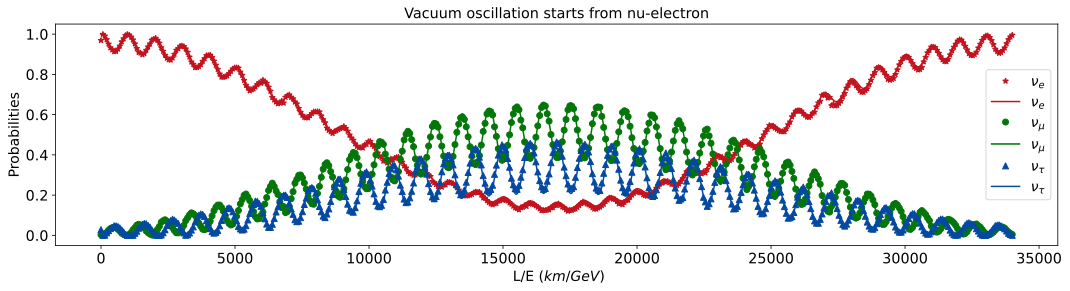

In [48]:
plt.figure(figsize=(18,4))
plt.xlabel(r' L/E ($km/GeV$)', fontsize=14) 
plt.ylabel(r'Probabilities',fontsize=14)
plt.plot(xexp, popus[:, 0], 'b*', color=seshadri[0], label=r'$\nu_e$')
plt.plot(xsim, etheo, color=seshadri[0], label=r'$\nu_e$')
plt.plot(xexp, popus[:, 1], 'yo', color=seshadri[3], label=r'$\nu_\mu$')
plt.plot(xsim, mtheo, color=seshadri[3], label=r'$\nu_\mu$')
plt.plot(xexp, popus[:, 2], 'g^', color=seshadri[1], label=r'$\nu_\tau$')
plt.plot(xsim, ttheo, color=seshadri[1], label=r'$\nu_\tau$')
plt.legend(fontsize=14)
plt.title('Vacuum oscillation starts from nu-electron')
plt.savefig('Vacuum oscillation starts from nu-electron')

In [ ]:
plt.figure(figsize=(18,4))
plt.xlabel(r' L/E ($km/GeV$)', fontsize=14) 
simulator = NeudCPMatter(dCP=0, initial='e', matter=0, sim=Lsim)
e_survival1a, mu_survival1a, tau_survival1a = simulator[0], simulator[1], simulator[2]
plt.ylabel(r'Probabilities',fontsize=14)  # label the y axis

plt.plot(Lsim,e_survival1a, color=seshadri[0], label=r'$\nu_e$')
plt.plot(Lsim,mu_survival1a, c=seshadri[3], label=r'$\nu_\mu$')
plt.plot(Lsim,tau_survival1a, c=seshadri[1], label=r'$\nu_\tau$')
plt.errorbar(x, ee_avg, yerr=calculate_avg_err(data_ee)[1],fmt="s", color=seshadri[0], capsize=2,capthick=2, label=r'$\nu_e$')
plt.errorbar(x, em_avg, yerr=calculate_avg_err(data_em)[1],fmt="o", color=seshadri[3], capsize=2,capthick=2, label=r'$\nu_\mu$')
plt.errorbar(x, et_avg, yerr=calculate_avg_err(data_et)[1],fmt="^",color=seshadri[1],  capsize=2,capthick=2, label=r'$\nu_\tau$')
plt.legend(fontsize=14)  # add the legend (will default to 'best' location)

In [32]:
popus

array([[9.68849831e-01, 2.86841774e-03, 2.82817508e-02],
       [9.99198923e-01, 7.68661206e-04, 3.24154374e-05],
       [9.90904505e-01, 8.10890273e-03, 9.86592100e-04],
       ...,
       [9.72924720e-01, 1.67826473e-02, 1.02926326e-02],
       [9.86790947e-01, 9.47804565e-03, 3.73100769e-03],
       [9.95476921e-01, 4.39571250e-03, 1.27366103e-04]])

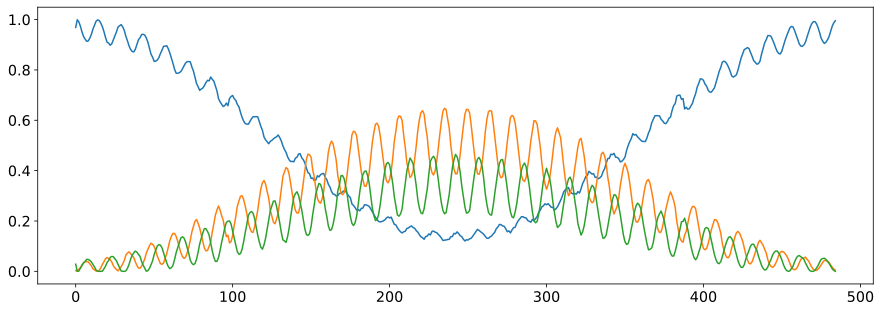

In [35]:
plt.plot(np.arange(popus.shape[0]), popus)

In [18]:
matter = 0
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
conL = 5.06773
E = 0.2*conL
dCP = 0
Lmin = 0
Lmax = 34000/4
theta_12 = t12
timestep = 97
Lreal = np.linspace(Lmin,Lmax,timestep)
alpha_2 = 2*np.arccos(cos(t13m)*cos(t23m))
alpha_1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(alpha_2/2))
alpha_3 = 2*np.arccos(cos(alpha_1/2)/cos(t13m))


schedules = []

for ii, l in enumerate(Lreal):
    l = l*conL # unit conversion
    d2 = D21m*l/(2*E)
    d3 = D31m*l/(2*E)
    phi_01 = d2
    phi_12 = -d2+d3
    U = R01_theory(alpha_1, pi/2+phi_01)@R12_theory(alpha_2, 3*pi/2+phi_12)@R01_theory(alpha_3-2*theta_12, pi/2+phi_01)@R01_theory(-alpha_3+2*theta_12, pi/2)@R12_theory(-alpha_2, 3*pi/2)@R01_theory(-alpha_1, pi/2)
    paras=get_parameter(U)
    new_sched = create_pulse_sequence([paras])
    schedules.append(new_sched)
schedules[-3].draw()

exp_circs = [create_qc(schedule) for schedule in schedules]
exp_circs = discr_circ + exp_circs

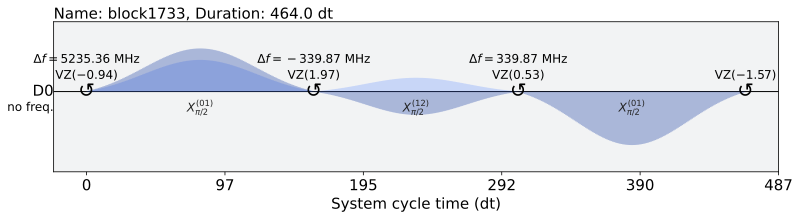

In [19]:
schedules[-3].draw()

In [20]:
test_job = backend.run(exp_circs, meas_level=1, meas_return='single', shots=NUM_SHOTS)
test_job.job_id()

'cjfdm8n6dei0664gjop0'

In [21]:
Lmin = 0
Lmax = 34000
timestep = 1000
sim = np.linspace(Lmin,Lmax,timestep)
etheo, mtheo, ttheo = NeudCPMatter(0, 't', 0, sim )[0], NeudCPMatter(0, 't', 0, sim)[1], NeudCPMatter(0, 't', 0, sim )[2]

first:'cje2r68l9m0cicv3a3n0'
next: 'cje2rtjqmesr7lh1ofe0'
next: 'cje2s8unq2dtf25lm960'
final:'cje2skrqmesr7lh1pjqg'

all:'cje2t28l9m0cicv3d5jg'

In [22]:
job = provider.backend.retrieve_job('cjf5ailtks61ugv04k4g')

In [23]:
data = get_job_data(job, average=False)
discrim_data = data[:3]
exp_data = data[3:]
LDA_012 = discriminate(discrim_data)

In [24]:
discr_data = count(discrim_data, LDA_012)
conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
conf_mat

[[0.9363, 0.0107, 0.053], [0.0108, 0.9486, 0.0406], [0.00825, 0.0381, 0.95365]]

In [25]:
populations = get_mitigated_population(exp_data, LDA_012, conf_mat)

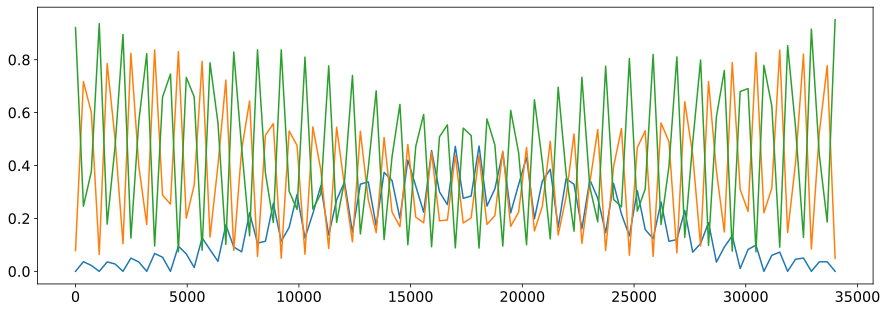

In [26]:
plt.plot(np.linspace(0, 34000, 97), populations)

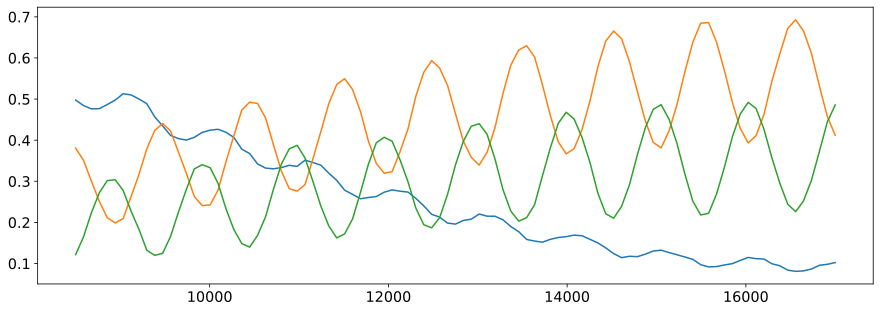

In [82]:
plt.plot(np.linspace(34000/4, 34000/2, 97), populations)

In [43]:
#muon 6 gates

In [41]:
matter = 0
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
conL = 5.06773
E = 0.2*conL
dCP = 0
Lmin = 0
Lmax = 34000
theta_12 = t12
timestep = 97
Lreal = np.linspace(Lmin,Lmax,timestep)
alpha_2 = 2*np.arccos(cos(t13m)*cos(t23m))
alpha_1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(alpha_2/2))
alpha_3 = 2*np.arccos(cos(alpha_1/2)/cos(t13m))

params_rx01 = [pi, 0, 0, 0, 0, 0, 0, 0, 0]
params_rx12 = [0, pi, 0, 0, 0, 0, 0, 0, 0]
params_g1 = [-alpha_1, 0, 0, pi/2, 0, 0, 0, 0, 0]
params_g2 = [0, -alpha_2, 0, 0, 3*pi/2, 0, 0, 0, 0]
params_g3 = [-alpha_3+2*theta_12, 0, 0, pi/2, 0, 0, 0, 0, 0]

schedules = []

for ii, l in enumerate(Lreal):
    l = l*conL # unit conversion
    d2 = D21m*l/(2*E)
    d3 = D31m*l/(2*E)
    phi_01 = d2
    phi_12 = -d2+d3
    params_g4 = [alpha_3-2*theta_12, 0, 0, pi/2+phi_01, 0, 0, 0, 0, 0]
    params_g5 = [0, alpha_2, 0, 0, 3*pi/2+phi_12, 0, 0, 0, 0]
    params_g6 = [alpha_1, 0, 0, pi/2+phi_01, 0, 0, 0, 0, 0]
    new_sched = create_pulse_sequence([params_rx01, params_g1, params_g2, params_g3, params_g4, params_g5, params_g6])
    schedules.append(new_sched)
schedules[-3].draw()

exp_circs = [create_qc(schedule) for schedule in schedules]
exp_circs = discr_circ + exp_circs 

In [42]:
muon_job = backend.run(exp_circs, meas_level=1, meas_return='return', shots=NUM_SHOTS)
muon_job.job_id()

'cjf57qdtks61ugv009v0'

In [44]:
#muon 3 gates

In [47]:
matter = 0
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
conL = 5.06773
E = 0.2*conL
dCP = 0
Lmin = 0
Lmax = 34000
theta_12 = t12
timestep = 97
Lreal = np.linspace(Lmin,Lmax,timestep)
alpha_2 = 2*np.arccos(cos(t13m)*cos(t23m))
alpha_1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(alpha_2/2))
alpha_3 = 2*np.arccos(cos(alpha_1/2)/cos(t13m))


schedules = []

for ii, l in enumerate(Lreal):
    l = l*conL # unit conversion
    d2 = D21m*l/(2*E)
    d3 = D31m*l/(2*E)
    phi_01 = d2
    phi_12 = -d2+d3
    U = R01_theory(alpha_1, pi/2+phi_01)@R12_theory(alpha_2, 3*pi/2+phi_12)@R01_theory(alpha_3-2*theta_12, pi/2+phi_01)@R01_theory(-alpha_3+2*theta_12, pi/2)@R12_theory(-alpha_2, 3*pi/2)@R01_theory(-alpha_1, pi/2)@R01_theory(pi, 0)
    paras=get_parameter(U)
    new_sched = create_pulse_sequence([paras])
    schedules.append(new_sched)
schedules[-3].draw()

exp_circs = [create_qc(schedule) for schedule in schedules]
exp_circs = discr_circ + exp_circs

In [48]:
muon_job = backend.run(exp_circs, meas_level=1, meas_return='return', shots=NUM_SHOTS)
muon_job.job_id()

'cjf59ultks61ugv03jig'

In [49]:
matter = 0
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
conL = 5.06773
E = 0.2*conL
dCP = 0
Lmin = 0
Lmax = 34000
theta_12 = t12
timestep = 97
Lreal = np.linspace(Lmin,Lmax,timestep)
alpha_2 = 2*np.arccos(cos(t13m)*cos(t23m))
alpha_1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(alpha_2/2))
alpha_3 = 2*np.arccos(cos(alpha_1/2)/cos(t13m))

params_rx01 = [pi, 0, 0, 0, 0, 0, 0, 0, 0]
params_rx12 = [0, pi, 0, 0, 0, 0, 0, 0, 0]
params_g1 = [-alpha_1, 0, 0, pi/2, 0, 0, 0, 0, 0]
params_g2 = [0, -alpha_2, 0, 0, 3*pi/2, 0, 0, 0, 0]
params_g3 = [-alpha_3+2*theta_12, 0, 0, pi/2, 0, 0, 0, 0, 0]

schedules = []

for ii, l in enumerate(Lreal):
    l = l*conL # unit conversion
    d2 = D21m*l/(2*E)
    d3 = D31m*l/(2*E)
    phi_01 = d2
    phi_12 = -d2+d3
    params_g4 = [alpha_3-2*theta_12, 0, 0, pi/2+phi_01, 0, 0, 0, 0, 0]
    params_g5 = [0, alpha_2, 0, 0, 3*pi/2+phi_12, 0, 0, 0, 0]
    params_g6 = [alpha_1, 0, 0, pi/2+phi_01, 0, 0, 0, 0, 0]
    new_sched = create_pulse_sequence([params_rx01, params_rx12, params_g1, params_g2, params_g3, params_g4, params_g5, params_g6])
    schedules.append(new_sched)
schedules[-3].draw()

exp_circs = [create_qc(schedule) for schedule in schedules]
exp_circs = discr_circ + exp_circs 

In [50]:
tau_job = backend.run(exp_circs, meas_level=1, meas_return='single', shots=NUM_SHOTS)
tau_job.job_id()

'cjf5ailtks61ugv04k4g'

In [60]:
def reconstruct(params):
    theta_1, theta_2, theta_3, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = params
    return U_d(phi_6, phi_5, phi_4) @ R01_theory(theta_3, phi_3) @ R12_theory(theta_2, phi_2) @ R01_theory(theta_1, phi_1)

In [51]:
matter = 0
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
conL = 5.06773
E = 0.2*conL
dCP = 0
Lmin = 0
Lmax = 34000
theta_12 = t12
timestep = 97
Lreal = np.linspace(Lmin,Lmax,timestep)
alpha_2 = 2*np.arccos(cos(t13m)*cos(t23m))
alpha_1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(alpha_2/2))
alpha_3 = 2*np.arccos(cos(alpha_1/2)/cos(t13m))


schedules = []

for ii, l in enumerate(Lreal):
    l = l*conL # unit conversion
    d2 = D21m*l/(2*E)
    d3 = D31m*l/(2*E)
    phi_01 = d2
    phi_12 = -d2+d3
    U = R01_theory(alpha_1, pi/2+phi_01)@R12_theory(alpha_2, 3*pi/2+phi_12)@R01_theory(alpha_3-2*theta_12, pi/2+phi_01)@R01_theory(-alpha_3+2*theta_12, pi/2)@R12_theory(-alpha_2, 3*pi/2)@R01_theory(-alpha_1, pi/2)@R12_theory(pi, 0)@R01_theory(pi, 0)
    paras=get_parameter(U)
    new_sched = create_pulse_sequence([paras])
    schedules.append(new_sched)
schedules[-3].draw()

exp_circs = [create_qc(schedule) for schedule in schedules]
exp_circs = discr_circ + exp_circs

In [52]:
tau_job = backend.run(exp_circs, meas_level=1, meas_return='single', shots=NUM_SHOTS)
tau_job.job_id()

'cjf5b10l9m0ciconmks0'

In [56]:
array_to_latex(reconstruct([np.pi, 0, 0, 0, 0, 0, 0, pi/2, pi/2]))

<IPython.core.display.Latex object>

In [73]:
array_to_latex(reconstruct(params_x12))

<IPython.core.display.Latex object>

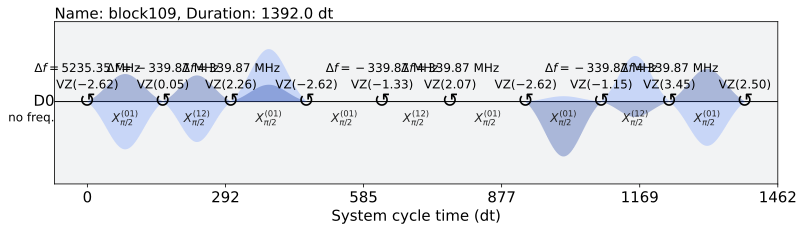

In [28]:
create_pulse_sequence([gate_params[0], gate_params[1], gate_params[0]]).draw()

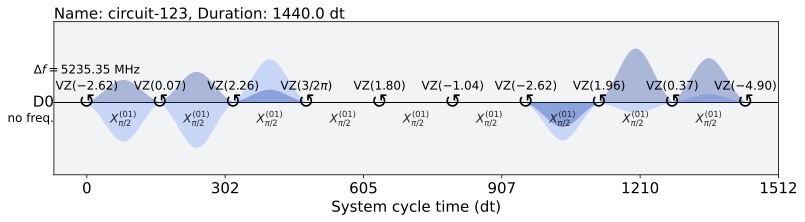

In [21]:
schedule(circs_wt_measure[0], backend=backend).draw()

In [124]:
job = provider.backend.retrieve_job('cjdqkaunq2dtf257eih0')

In [125]:
data = get_job_data(job, average=False)
discrim_data = data[:3]
exp_data = data[3:]
LDA_012 = discriminate(discrim_data)

#discr_data = count(discrim_data, LDA_012)
#confusion matrix
#conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   #range(np.shape(discr_data)[0])] 
#conf_mat

In [88]:
data_counts = count(exp_data, LDA_012)

In [90]:
def population_dic(dic):
    return [dic['0']/NUM_SHOTS, dic['1']/NUM_SHOTS, dic['2']/NUM_SHOTS]

In [126]:
conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                   range(np.shape(discr_data)[0])] 
conf_mat

[[0.9527, 0.0121, 0.0352],
 [0.01525, 0.9301, 0.05465],
 [0.0133, 0.05855, 0.92815]]

In [127]:
populations = get_mitigated_population(exp_data, LDA_012, conf_mat)

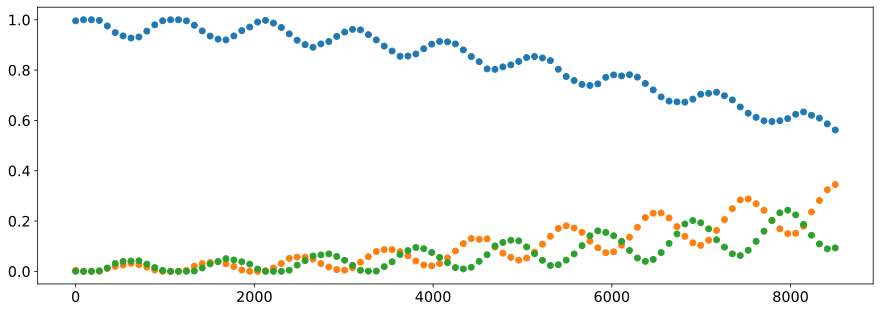

In [134]:
plt.scatter(Lreal, populations[:, 0])
plt.scatter(Lreal, populations[:, 1])
plt.scatter(Lreal, populations[:, 2])
#plt.savefig('neutrinos_0')

In [22]:
def parameters(a):
    Dee = c12**2*D31+s12**2*D32
    Dee_t = Dee*sqrt((cos(2*t13)-a/Dee)**2+sin(2*t13)**2)
    s13t_sq = 0.5*(1-(Dee*cos(2*t13)-a)/Dee_t)
    t13t = np.arcsin(sqrt(s13t_sq))
    a12 = 0.5*(a+Dee-Dee_t)
    D21t = D21*sqrt((cos(2*t12)-a12/D21)**2 + cos(t13-t13t)**2*sin(2*t12)**2)
    s12t_sq = 0.5*(1-(D21*cos(2*t12)-a12)/D21t)
    t12t = np.arcsin(sqrt(s12t_sq))
    D31t = D31+a/4+0.5*(D21t-D21)+0.75*(Dee_t-Dee)
    t23t = t23
    return t23t,t13t, t12t, D21t, D31t
def NeudCPMatter(dCP, initial, matter, sim):
    try:
        if initial == 'e':
            flavor_initial = [1,0,0]
        elif initial == 'm':
            flavor_initial = [0,1,0]
        elif initial == 't':
            flavor_initial = [0,0,1]
    except:
        print('start from e, m, t only')
    t23m, t13m, t12m, D21m, D31m = parameters(matter)
    dCPm = dCP
    c12m = cos(t12m)
    s12m = sin(t12m)
    c13m = cos(t13m)
    s13m = sin(t13m)
    c23m = cos(t23m)
    s23m = sin(t23m)
    
    Um = np.array([[c12m*c13m            , s12m*c13m             , s13m*exp(-1j*dCP)],
               [-s12m*c23m-c12m*s23m*s13m*exp(1j*dCP), c12m*c23m-s12m*s23m*s13m*exp(1j*dCP) , s23m*c13m],
               [s12m*s23m-c12m*c23m*s13m*exp(1j*dCP) , -c12m*s23m-s12m*c23m*s13m*exp(1j*dCP), c23m*c13m]])
    iUm = Um.conj().T
    # U1 = R01(pi/2+dCP, a1m)@R12(3*pi/2, a2m)@R01(pi/2+dCP, a3)@R01(pi/2,-2*t12m)
    # U1d = R01(pi/2, 2*t12m)@R01(pi/2+dCP, -a3m)@R12(3*pi/2, -a2m)@R01(pi/2+dCP, -a1m)
    e_survival1a = []
    mu_survival1a = []
    tau_survival1a = []
    conL = 5.06773
    
    for l in sim:
        l = l*conL
        evolmatrix = np.diag([1, exp(-1j*D21m*l/(2*E)), exp(-1j*l*D31m/(2*E))])
        # flavor = U1@evolmatrix@U1d@flavor_initial
        flavor = Um@evolmatrix@iUm@flavor_initial
        e_survival1a.append(np.absolute(flavor[0])**2)
        mu_survival1a.append(np.absolute(flavor[1])**2)
        tau_survival1a.append(np.absolute(flavor[2])**2)
    return e_survival1a, mu_survival1a, tau_survival1a

In [32]:
Lmin = 0
Lmax = 34000
conL = 5.06773
E = 0.2*conL
timestep = 1000
sim = np.linspace(Lmin,Lmax,timestep)


In [33]:
sim = np.linspace(Lmin,Lmax,timestep)
etheo, mtheo, ttheo = NeudCPMatter(0, 't', 0, sim )[0], NeudCPMatter(0, 't', 0, sim)[1], NeudCPMatter(0, 't', 0, sim )[2]

In [34]:
xaxis = np.linspace(Lmin,34000,97)


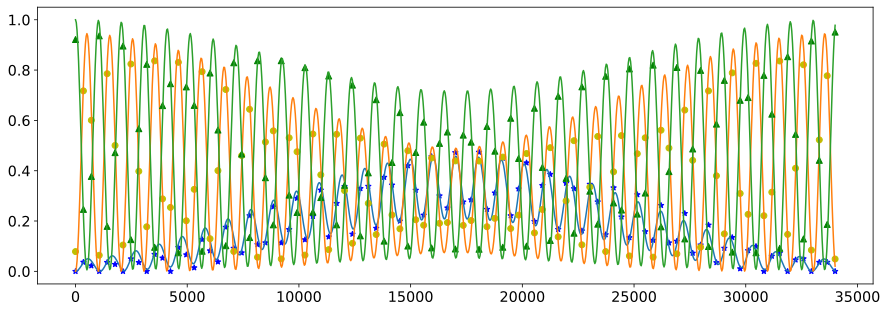

In [37]:
plt.plot(xaxis, populations[:, 0], 'b*')
plt.plot(sim, etheo)
plt.plot(xaxis, populations[:, 1], 'yo')
plt.plot(sim, mtheo)
plt.plot(xaxis, populations[:, 2], 'g^')
plt.plot(sim, ttheo)
plt.savefig('neutrino_oscilation_nice_2')

In [51]:
def NeudCPMatter_v2(dCP, initial, matter, sim):
    try:
        if initial == 'e':
            flavor_initial = [1,0,0]
        elif initial == 'm':
            flavor_initial = [0,1,0]
        elif initial == 't':
            flavor_initial = [0,0,1]
    except:
        print('start from e, m, t only')
    t23m, t13m, t12m, D21m, D31m = parameters(matter)
    dCPm = dCP
    c12m = cos(t12m)
    s12m = sin(t12m)
    c13m = cos(t13m)
    s13m = sin(t13m)
    c23m = cos(t23m)
    s23m = sin(t23m)
    
    #Um = #np.array([[c12m*c13m            , s12m*c13m             , s13m*exp(-1j*dCP)],
               #[-s12m*c23m-c12m*s23m*s13m*exp(1j*dCP), c12m*c23m-s12m*s23m*s13m*exp(1j*dCP) , s23m*c13m],
               #[s12m*s23m-c12m*c23m*s13m*exp(1j*dCP) , -c12m*s23m-s12m*c23m*s13m*exp(1j*dCP), c23m*c13m]])
    #iUm = Um.conj().T
    # U1 = R01(pi/2+dCP, a1m)@R12(3*pi/2, a2m)@R01(pi/2+dCP, a3)@R01(pi/2,-2*t12m)
    # U1d = R01(pi/2, 2*t12m)@R01(pi/2+dCP, -a3m)@R12(3*pi/2, -a2m)@R01(pi/2+dCP, -a1m)
    e_survival1a = []
    mu_survival1a = []
    tau_survival1a = []
    conLl = 5.06773
    
    for l in sim:
        l = l*conLl
        d2 = D21m*l/(2*E)
        d3 = D31m*l/(2*E)
        phi_01 = d2
        phi_12 = -d2+d3
        #evolmatrix = np.diag([1, exp(-1j*D21m*l/(2*E)), exp(-1j*l*D31m/(2*E))])
        # flavor = U1@evolmatrix@U1d@flavor_initial
        #flavor = Um@evolmatrix@iUm@flavor_initial
        flavor = R01_theory(alpha_1, pi/2+phi_01)@R12_theory(alpha_2, 3*pi/2+phi_12)@R01_theory(alpha_3-2*theta_12, pi/2+phi_01)@R01_theory(-alpha_3+2*theta_12, pi/2)@R12_theory(-alpha_2, 3*pi/2)@R01_theory(-alpha_1, pi/2)@flavor_initial
        e_survival1a.append(np.absolute(flavor[0])**2)
        mu_survival1a.append(np.absolute(flavor[1])**2)
        tau_survival1a.append(np.absolute(flavor[2])**2)
    return e_survival1a, mu_survival1a, tau_survival1a

In [ ]:
Energy = np.linspace(0.1, 2, 97)
conL = 5.06773
L = 295*conL
for E in Energy:

In [53]:
t12 = np.radians(33.45)
t23 = np.radians(42.1)
t13 = np.radians(8.62)
D21 = 7.42*1e-5
D31 = 2.510*1e-3 #
D32 = D31-D21 ###
# Now gate simulator
c12 = cos(t12)
s12 = sin(t12)
c13 = cos(t13)
s13 = sin(t13)
c23 = cos(t23)
s23 = sin(t23)

In [54]:
dCP = 0
# U1 is the PMNS matrix
U1 = np.array([[c12*c13            , s12*c13             , s13*exp(-1j*dCP)],
               [-s12*c23-c12*s23*s13*exp(1j*dCP), c12*c23-s12*s23*s13*exp(1j*dCP) , s23*c13 ],
               [s12*s23-c12*c23*s13*exp(1j*dCP) , -c12*s23-s12*c23*s13*exp(1j*dCP), c23*c13 ]])
U1d = U1.conj().T # conjugate transpose

In [55]:
def Evol(n, E):
    evol = np.diag([1, exp(-1j*D21*L/(2*E*n)), exp(-1j*L*D31/(2*E*n))])
    return evol

In [56]:
def U0(s):
    U0 = U1@Evol(s, E)@U1d
    return U0